In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from datetime import timedelta
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')



np.seterr(divide = 'ignore') 


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Declaração das Funções

In [3]:
from lifetimes import BetaGeoFitter

# Função para criar o modelo BG/NBD
def criarModeloBGF(dadosRFM #Dataset já processado pelo RFM
                   ,teste = True #Caso seja para efetuar a predição em um dataset com ou sem o período de observação
                   ,penalizer = 0.01# Coeficiente de penalização usado pelo modelo
                  ):
    # instantiation of BG-NBD model
    bgf = BetaGeoFitter(penalizer_coef=penalizer)

    # fitting of BG-NBD model
    if teste:
        bgf.fit(frequency=dadosRFM['frequency_cal'],
                recency=dadosRFM['recency_cal'],
                T=dadosRFM['T_cal'])
    else:
        bgf.fit(frequency=dadosRFM['frequency'],
                recency=dadosRFM['recency'],
                T=dadosRFM['T'])

    return bgf

#Dado um período, retorna o número de transações esperadas até lá
def comprasEsperadas(model #Modelo BG/NBD ou de Pareto esperado para realizar a predição
                     ,rfm #Dataset já processado pelo RFM
                     ,numPeriodos = 180 #Numero de períodos em dia para que deseja efetuar a predição
                     , teste = True #Caso seja para efetuar a predição em um dataset com ou sem o período de observação
                    ):
    if teste:
        return model.conditional_expected_number_of_purchases_up_to_time(numPeriodos, rfm['frequency_cal'].values, rfm['recency_cal'].values, rfm['T_cal'].values)
    return model.conditional_expected_number_of_purchases_up_to_time(numPeriodos, rfm['frequency'].values, rfm['recency'].values, rfm['T'].values)


In [4]:
def getPeriodosList(df, dateColumn = "date",frequencia = "W"):
    def to_period(d):
        return d.to_period(frequencia)
        
    df["period"] = df[dateColumn].map(to_period)
    df = df.sort_values(by='period')
    return df.period.unique()

In [5]:
from lifetimes.utils import calibration_and_holdout_data,summary_data_from_transaction_data


#Processa um dataset de acordo com o padrão RFMT
# O retorno desta função consiste em:
#Se teste for true : Retorna o dataset considerando a data de divisão para dividir o período de 'calibração' e 'holdout'.
#Se for falso: Retorna todo o dataset processado pelo padrão RFMT.
def RFM_Progressivo(df #Dataframe que será feito
                 ,colunaID #Nome da coluna onde encontra-se os identificadores
                 ,colunaData  #Nome da coluna onde encontra-se as datas
                 ,colunaValor  #Nome da coluna onde encontra-se os valores monetários
                 ,frequencia = 'W' #Frequência em que será observado, Ex: "W" - Weeks
                 ,calibrationEnd = None #Caso queira passar a data do fim do período de calibração
                 ,ObservationEnd = None #Caso queira passar a data do fim do período de Obsersvação
                 ,minTrainTime = 20 # Porcentagem da divisão dos dados para separar em Obsersvação e calibração
                ,intervalosPredicao = 4
                 , teste = True #Verdadeiro caso queira separar os dados em Obsersvação e calibração
                ):
    #arquivo.close()
    if calibrationEnd == None:
        periodos = getPeriodosList(df,colunaData,frequencia)
        calibrationEnd = periodos[minTrainTime].to_timestamp()
        ObservationEnd = periodos[minTrainTime+intervalosPredicao].to_timestamp()
        
    if teste == False:
        return summary_data_from_transaction_data(transactions=df,
                                                  customer_id_col=colunaID, 
                                                   datetime_col=colunaData,
                                                   monetary_value_col = colunaValor,
                                                   freq=frequencia)
    else:
        rfm_cal_holdout = calibration_and_holdout_data(transactions=df,
                                                  customer_id_col=colunaID, 
                                                   datetime_col=colunaData,
                                                   monetary_value_col = colunaValor,
                                                   freq=frequencia,
                                                   calibration_period_end=calibrationEnd,
                                                   observation_period_end=ObservationEnd)
        return rfm_cal_holdout

#rfm = RFM_Progressivo(df,'customer_index','date','amount',teste=True)
#rfm.head(3)

In [6]:
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import ParameterSampler

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

#Função utilizada para criar os modelos de regressão
#Retorna o MSE e o modelo
def createModelRegressor(RegressorModel #Modelo que será treinado (Tem de ter a função fit e predict implementadas)
                         , X_train #Dados que serão usados para o treino
                         , X_test #Dados que serão usados para o teste
                         , Y_train #Targets dos dados de treino
                         , Y_test #Targets dos dados de testes
                        ): 
    regressor = RegressorModel
    regressor.fit(X_train, Y_train)
    pred = regressor.predict(X_test)
    mse = mean_squared_error(Y_test, pred) #Utilizando o MSE, caso queira outra métrica, trocar nesta parte!
    return mse, regressor #Retorna o MSE e o Regressor


#Função feita para escolher o melhor modelo de acordo com a situação
#Retorna o melho modelo para a situação
def escolheModelo(dfRFM #Dataframe já processado pelo RFM
                  ,target = 'monetary_value_holdout' #Nome da coluna de target, sendo a coluna de valor monetário prevista ou frequência
                  , tunning = False #Caso queira fazer o Tunning de hyperparâmetros, deixar como true
                 ):
    #Colunas utilizadas para treino
    Xcol = ['frequency', 'recency', 'T', 'monetary_value']
    #Colunas utilizadas para target
    Ycol = [target]

    X = dfRFM[Xcol]
    Y = dfRFM[Ycol]

    X_train, X_test, Y_train, Y_test = train_test_split(X.values, np.ravel(Y.values), random_state=42)
    
    if tunning == False:
        lasso = LassoCV()
        Enet = ElasticNet()
        rf = RandomForestRegressor()
        krr = KernelRidge()
        GBoost = GradientBoostingRegressor()
        HGBoost = HistGradientBoostingRegressor()
        model_xgb = xgb.XGBRegressor()
        model_lgb = lgb.LGBMRegressor(objective='regression',verbose=-1)
    
    else:
        #lasso = LassoCV()
        grid = {'n_alphas' : [100,200,500,100],'max_iter' : [1000,1500,2000], 'random_state' : [42]}
        lasso = GridSearchCV(estimator=LassoCV(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")

        grid = {"max_iter": [1000,1500,2000],"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],"l1_ratio": np.arange(0.0, 1.0, 0.1), 'random_state' : [42]}
        Enet = GridSearchCV(estimator=ElasticNet(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #Enet = ElasticNet()

        grid = {'bootstrap': [True, False],'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 800, 1000],'random_state' : [42]}    
        rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #rf = RandomForestRegressor()

        grid = {"alpha": [0.001, 0.01, 0.1, 1,], "coef0" : [0.01,0.1,1,10,100] ,'degree_': [1,3,5,10],'random_state':[42]}
        krr = GridSearchCV(estimator=KernelRidge(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #krr = KernelRidge()

        grid = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[42]}
        GBoost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #GBoost = GradientBoostingRegressor()
        grid = {'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4,None],'max_leaf_nodes' : [31,None],'random_state':[42]}

        HGBoost = GridSearchCV(estimator=HistGradientBoostingRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #HGBoost = HistGradientBoostingRegressor()

        grid = { 'max_depth': [3,6,10],'learning_rate': [0.01, 0.05, 0.1],'n_estimators': [100, 500, 1000],'colsample_bytree': [0.3, 0.7],'random_state':[42]}
        #model_xgb = xgb.XGBRegressor()
        model_xgb = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #model_lgb = lgb.LGBMRegressor(objective='regression')
        model_lgb =GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
    
    
    models = [lasso, Enet, rf, GBoost, HGBoost, model_xgb, model_lgb]#,krr]
    bestModel, bestScore = None, None
    for i in models:
        score = createModelRegressor(i, X_train, X_test, Y_train, Y_test)
        if bestScore == None or bestScore > score[0]:
            bestScore, bestModel = score
        if tunning:
            pass
            #print(type(i.best_estimator_).__name__, " mse: {:.4f} \n".format(score[0]))
        else:
            print(type(i).__name__, " mse: {:.4f} \n".format(score[0]))
            #pass

    if tunning :
        return bestModel.best_estimator_
    else:
        return bestModel
    #prediction = bestModel.predict(X_test[Xcol])
    #X_test['ExpectedML'] = prediction
    #X_test['Real Expected'] = Y_test
    #return X_test



def escolheModeloCustom(X_train, X_test, Y_train, Y_test#
                  ,target = 'monetary_value_holdout' #Nome da coluna de target, sendo a coluna de valor monetário prevista ou frequência
                  , tunning = False #Caso queira fazer o Tunning de hyperparâmetros, deixar como true
                 ):

    if tunning == False:
        lasso = LassoCV()
        Enet = ElasticNet()
        rf = RandomForestRegressor()
        krr = KernelRidge()
        GBoost = GradientBoostingRegressor()
        HGBoost = HistGradientBoostingRegressor()
        model_xgb = xgb.XGBRegressor()
        model_lgb = lgb.LGBMRegressor(objective='regression',verbose=-1)
    
    else:
        #lasso = LassoCV()
        grid = {'n_alphas' : [100,200,500,100],'max_iter' : [1000,1500,2000], 'random_state' : [42]}
        lasso = GridSearchCV(estimator=LassoCV(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")

        grid = {"max_iter": [1000,1500,2000],"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],"l1_ratio": np.arange(0.0, 1.0, 0.1), 'random_state' : [42]}
        Enet = GridSearchCV(estimator=ElasticNet(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #Enet = ElasticNet()

        grid = {'bootstrap': [True, False],'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 800, 1000],'random_state' : [42]}    
        rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #rf = RandomForestRegressor()

        grid = {"alpha": [0.001, 0.01, 0.1, 1,], "coef0" : [0.01,0.1,1,10,100] ,'degree_': [1,3,5,10],'random_state':[42]}
        krr = GridSearchCV(estimator=KernelRidge(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #krr = KernelRidge()

        grid = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[42]}
        GBoost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #GBoost = GradientBoostingRegressor()
        grid = {'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4,None],'max_leaf_nodes' : [31,None],'random_state':[42]}

        HGBoost = GridSearchCV(estimator=HistGradientBoostingRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #HGBoost = HistGradientBoostingRegressor()

        grid = { 'max_depth': [3,6,10],'learning_rate': [0.01, 0.05, 0.1],'n_estimators': [100, 500, 1000],'colsample_bytree': [0.3, 0.7],'random_state':[42]}
        #model_xgb = xgb.XGBRegressor()
        model_xgb = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
        #model_lgb = lgb.LGBMRegressor(objective='regression')
        model_lgb =GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=grid, n_jobs=-1, scoring="neg_mean_squared_error")
    
    
    models = [lasso, Enet, rf, GBoost, HGBoost, model_xgb, model_lgb]#,krr]
    bestModel, bestScore = None, None
    for i in models:
        score = createModelRegressor(i, X_train, X_test, Y_train, Y_test)
        if bestScore == None or bestScore > score[0]:
            bestScore, bestModel = score
        if tunning:
            pass
            #print(type(i.best_estimator_).__name__, " mse: {:.4f} \n".format(score[0]))
        else:
            #print(type(i).__name__, " mse: {:.4f} \n".format(score[0]))
            pass

    if tunning :
        return bestModel.best_estimator_
    else:
        return bestModel


#escolheModelo(rfm,target = 'frequency_holdout')



In [7]:
def getBauerDatasetSplitTimes(timeCol,outputSize):
  vals = timeCol.unique()
  max_data = timeCol.max()
  training_start = vals[0]
  training_end   = vals[max_data - (outputSize*2) - 1]
  holdout_start  = vals[max_data - (outputSize*2)]
  holdout_end    = vals[max_data - outputSize]
  return training_start,training_end,holdout_start,holdout_end

### Modelos Eniac

In [8]:
from lifetimes import BetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes import GammaGammaFitter


# Função para criar o modelo BG/NBD
def criarModeloBGF(dadosRFM #Dataset já processado pelo RFM
                   ,teste = True #Caso seja para efetuar a predição em um dataset com ou sem o período de observação
                   ,penalizer = 0.1# Coeficiente de penalização usado pelo modelo
                  ):
    # instantiation of BG-NBD model
    bgf = BetaGeoFitter(penalizer_coef=penalizer)

    # fitting of BG-NBD model
    if teste:
        bgf.fit(frequency=dadosRFM['frequency_cal'],
                recency=dadosRFM['recency_cal'],
                T=dadosRFM['T_cal'])
    else:
        bgf.fit(frequency=dadosRFM['frequency'],
                recency=dadosRFM['recency'],
                T=dadosRFM['T'])

    return bgf


# Função para criar o modelo de Pareto/NBD
def criarModeloPareto(dadosRFM #Dataset já processado pelo RFM
                      ,teste = True  #Caso seja para efetuar a predição em um dataset com ou sem o período de observação
                      ,penalizer = 0.1# Coeficiente de penalização usado pelo modelo
):
    # instantiation of Pareto model
    pareto = ParetoNBDFitter(penalizer_coef=penalizer)

    # fitting of the model
    if teste:
        pareto.fit(frequency=dadosRFM['frequency_cal'],
                recency=dadosRFM['recency_cal'],
                T=dadosRFM['T_cal'])
    else:
        pareto.fit(frequency=dadosRFM['frequency'],
                recency=dadosRFM['recency'],
                T=dadosRFM['T'])

    return pareto


#Função para criar o modelo que prevê o valor monetário médio de cada cliente, usando o modelo Gamma Gamma.
#Retorna o dataset com a coluna 'ExpectedGammaGamma'
def preverValorGGF(rfm, #Dataset já processado pelo RFM
                   coefPenalizacao = 0.01, #Coeficiente de penalização utilizada pelo Gamma Gamma
                   teste = True #Caso seja para efetuar a predição em um dataset com ou sem o período de observação
                  ):
    monetary = "monetary_value"
    frequency = "frequency"
    if teste:
        monetary = "monetary_value_cal"
        frequency = "frequency_cal"
    ggf = GammaGammaFitter(coefPenalizacao)
    
    rfm = rfm[rfm[monetary] > 0]
    rfm = rfm[rfm[frequency] > 0]

    ggf.fit(rfm[frequency],rfm[monetary])
    return ggf


#Dado um período, retorna o número de transações esperadas até lá
def comprasEsperadas(model #Modelo BG/NBD ou de Pareto esperado para realizar a predição
                     ,rfm #Dataset já processado pelo RFM
                     ,numPeriodos = 180 #Numero de períodos em dia para que deseja efetuar a predição
                     , teste = True #Caso seja para efetuar a predição em um dataset com ou sem o período de observação
                    ):
    if teste:
        return model.conditional_expected_number_of_purchases_up_to_time(numPeriodos, rfm['frequency_cal'].values, rfm['recency_cal'].values, rfm['T_cal'].values)
    return model.conditional_expected_number_of_purchases_up_to_time(numPeriodos, rfm['frequency'].values, rfm['recency'].values, rfm['T'].values)


In [9]:

def testarModelosPredicaoCumulativa(df,
                                    minTraining = 16, #Qual é o periodo mínimo que será usado para treino
                                    maxTraining = 40, #Qual será o último período que será usado para o treino
                                    intervalosPredicao = 4, #Define quantos períodos serão os intervalos de predição
                                    cID = "customer_index", #Nome da coluna contendo o ID dos clientes
                                    cDate = "date",#Nome da coluna onde contém a data das compras
                                    cMonetary = 'amount', #Nome da coluna onde contém a média dos valores monetários
                                    frequencia = "s",
                                    calculateTransactions = True,
                                    calculateMonetary = True,
                                    penalizer = 0.01
                                   ):
    

    dfResultados =  summary_data_from_transaction_data(df[df["WeekID"] <= maxTraining], 
                                                    cID, 
                                                    cDate, 
                                                    monetary_value_col = cMonetary,freq = frequencia).reset_index()[[cID]].set_index(cID)

    
    for periodo in range(minTraining,maxTraining,intervalosPredicao):
        calibrationDate = periodo #8
        #Validar com os próximos intervalos.
        validationEnd = periodo + intervalosPredicao       #12 
        predictDate = periodo + (intervalosPredicao*2)    #16
        print(calibrationDate,validationEnd,predictDate)   


        XTrain = summary_data_from_transaction_data(df[df["WeekID"] <= calibrationDate], 
                                                   cID, cDate, 
                                                   monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        Ytrain = summary_data_from_transaction_data(df[df["WeekID"] <= validationEnd], 
                                                    cID, 
                                                    cDate, 
                                                    monetary_value_col = cMonetary,
                                                   freq = frequencia)

        Ytrain = Ytrain.rename(columns={"frequency" : "frequency_holdout", "monetary_value" : "monetary_holdout"})[["frequency_holdout","monetary_holdout"]]

        
        XTest = summary_data_from_transaction_data(df[df["WeekID"] <= validationEnd], cID, cDate, monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        YTest = summary_data_from_transaction_data(df[df["WeekID"] <= predictDate], cID, cDate, monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        
        YTest = YTest.rename(columns={"frequency" : "frequency_holdout", "monetary_value" : "monetary_holdout"})[["frequency_holdout","monetary_holdout"]]
        
        #XTrain = pd.concat([XTrain, Ytrain], axis=1, join="inner")
        #XTest = pd.concat([XTest, YTest], axis=1, join="inner")
        XTrain = pd.merge(XTrain, Ytrain,how='inner',left_index=True, right_index=True)
        XTest = pd.merge(XTest, YTest,how='inner',left_index=True, right_index=True)
        if calculateTransactions:
            start = time.time()
            print(f"Periodo {periodo} de {maxTraining}\n\n")
            #print("Criando modelo BG/NBD")
            modelBGF = criarModeloBGF(XTrain, teste = False,penalizer = penalizer)
            end = time.time()
            print("Tempo BG/NBD: ",timedelta(seconds = end - start))
            print(modelBGF)
            start = time.time()
           # print("Criando modelo Pareto")
            modelPareto = criarModeloPareto(XTrain,teste = False,penalizer = penalizer)
            print(modelPareto)
            end = time.time()
            print("Tempo Pareto: ",timedelta(seconds = end - start))

            start = time.time()
            modelML = escolheModelo(XTrain,target = 'frequency_holdout')
            end = time.time()
            print("Tempo ML: ",timedelta(seconds = end - start))

            
            XTest['ExpectedMLT '+str(predictDate)] = modelML.predict(XTest[['frequency', 'recency', 'T', 'monetary_value']])
            XTest['Real Expected Transactions'+str(predictDate)] = YTest['frequency_holdout']
            XTest['ExpectedPareto '+str(predictDate)] = comprasEsperadas(modelPareto, XTest,numPeriodos = 7*intervalosPredicao,teste = False)
            XTest['ExpectedBGF '+str(predictDate)] = comprasEsperadas(modelBGF, XTest,numPeriodos = 7*intervalosPredicao,teste = False)

            #dfResultados[dfResultados['ExpectedML '+str(periodo + (intervalosPredicao*2))] < 0]= 0
        if calculateMonetary:
            ggf = preverValorGGF(XTrain, #Dataset já processado pelo RFM
                   coefPenalizacao = penalizer, #Coeficiente de penalização utilizada pelo Gamma Gamma
                   teste = False #Caso seja para efetuar a predição em um dataset com ou sem o período de observação
                  )

            XTest['ExpectedGGF '+str(predictDate)] = ggf.conditional_expected_average_profit(XTest["frequency"], XTest["monetary_value"]).values
            start = time.time()
            modelML = escolheModelo(XTrain,target = 'monetary_holdout')
            end = time.time()
            print("Tempo MLT: ",timedelta(seconds = end - start))
            XTest['ExpectedMLM '+str(predictDate)] = modelML.predict(XTest[['frequency', 'recency', 'T', 'monetary_value']])
            XTest['Real Expected Monetary'+str(predictDate)] = YTest['monetary_holdout']

        dfResultados = pd.merge(dfResultados,XTest.drop(['frequency', 'recency', 'T', 'monetary_value', 'frequency_holdout',
       'monetary_holdout'], axis = 1),how = "left",
                            left_index=True, right_index=True)
            #dfResultados[dfResultados['ExpectedML '+str(periodo + (intervalosPredicao*2))] < 0]= 0    
    return dfResultados

### Solução

### Utilizando o Prophet com a Solução

In [10]:
from prophet import Prophet

def prophet_features(df,dateCol = "",monetaryCol = "",horizon=4):
    temp_df = df.reset_index()
    #temp_df = temp_df.groupby(dateCol)[monetaryCol].sum().reset_index()
    temp_df = temp_df[[dateCol, monetaryCol]]
    temp_df.rename(columns={dateCol: 'ds', monetaryCol: 'y'}, inplace=True)

    #define prophet model
    m = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False
            )
    #train prophet model
    m.fit(temp_df)
    future = m.make_future_dataframe(periods=4, freq = "W")        
    features = m.predict(future)
    return pd.merge(df, features, left_on=[dateCol], right_on=['ds'], how='inner')

In [11]:
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from matplotlib import pyplot


def TrainModelWithProphet(df,end = 44,starting = 8,useProphet = True,dataInicial = pd.Timestamp('1960-01-01'),monetary = "sumProfit"):
    #trainCols = ['CustomerID', 'WeekID','firstRecentGapBetweenOrders', 'meanOrderProfit','diffMaxMinOrderProfit', 'daysSinceLastOrder']
    trainCols = ['CustomerID', 'WeekID', 'sumProfit', 'numberOfUniqueItems','timeSinceLastPurchase', 
                 'timeSinceFirstPurchase', 'cumSumPurchases',"numberOfOrders", "meanOrderProfit"]
    if useProphet:
        df["WeekDay"] = pd.to_datetime(df["WeekID"],unit='W',origin=dataInicial)
        trainColsProphet = ['CustomerID', 'WeekID', 'sumProfit', 'numberOfUniqueItems','timeSinceLastPurchase', 
                     'timeSinceFirstPurchase', 'cumSumPurchases',"numberOfOrders", "meanOrderProfit",
                     'trend','yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
                     'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
                     'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
                     'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
                     'multiplicative_terms_upper', 'yhat']
    mseDict = {}
    #targetCol = ["meanOrderProfit"]
    targetCol = ["numberOfOrders", "meanOrderProfit"]
    dfResultados = pd.DataFrame()
    for target in targetCol:
        for i in range(starting,end,1):
            if useProphet:
                dfSlice = df[df["WeekID"] <= i]
                dfSlice = prophet_features(dfSlice,"WeekDay",monetary)
            else:
                dfSlice = df[df["WeekID"] <= i]
            
            dfTreino = dfSlice[ (dfSlice["WeekID"] == i-4)]
            dfValid =  dfSlice[ (dfSlice["WeekID"] == i)]
            dfPredict = df[ (df["WeekID"] == i+4)]
            
            

            
            print(f"Training with in : {str(i)}")
            X_train_Array = dfTreino[trainCols]
            Y_train_Array =  dfValid[target]

            print(f"Using {i+4} to validate")
            X_valid_Array = dfValid[trainCols]
            Y_valid_Array = dfPredict[target]
            
            model = xgb.XGBRegressor()
            trainHistory = model.fit(
                            X_train_Array,
                            Y_train_Array)

            pred = model.predict(X_valid_Array)
            
            
            dfResultados['ExpectedML '+str(target)+" "+str(i+4)] = list(pred)
            dfResultados['Real Expected '+str(target)+" "+str(i+4)]  =  Y_valid_Array.values
            #mseDict[i] = mean_squared_error(Y_valid_Array.values, pred)
            #print("Mse ",mseDict[i])
            #print("MSE Sem o Prophet:", mean_squared_error(Y_valid_Array.values, pred))
            #print(model.feature_importances_)
            #print(X_train_Array.columns)
            
            if useProphet:
                modelProphet = xgb.XGBRegressor()
                trainHistory = modelProphet.fit(
                                dfTreino[trainColsProphet],
                                dfValid[target])
    
                pred = modelProphet.predict(dfValid[trainColsProphet])
                #print("MSE com o Prophet:", mean_squared_error(Y_valid_Array.values, pred))
                #print(dfTreino[trainColsProphet].columns)
                #print(modelProphet.feature_importances_)


                
                dfResultados['ExpectedMLP '+str(target)+" "+str(i+4)] = list(pred)

    return dfResultados


#dfResultados = TrainModelWithProphet(df,dataInicial = dataInicial,starting = 10)

### Cálculo de Métricas

In [12]:
import statsmodels.stats.api as sms

def intervaloConfiancaErros(Y,Predicted):
    errors = abs(Y - Predicted)
    # Nível de confiança
    confidence_level = 0.95
    #print(errors.mean())
    # Calcular o intervalo de confiança para a média dos erros de previsão
    ci = sms.DescrStatsW(errors).tconfint_mean(alpha=1-confidence_level)
    return ci

In [13]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score, max_error

def root_mean_squared_error(y_true, y_pred):
    """ Calcula o RMSE manualmente """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def retornarMétricas(TrueValues, Predicted, metricList=None, dataName="Dataset"):
    if metricList is None:
        metricList = [mean_absolute_error, root_mean_squared_error, intervaloConfiancaErros]  
    res = {}
    for metric in metricList:
        res[metric.__name__] = metric(TrueValues, Predicted)

    return res

    

In [14]:
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error,r2_score,max_error


def retornarMétricas(TrueValues,Predicted, metricList = None,dataName = "Dataset"):
    if metricList == None:
        metricList = [mean_squared_error,mean_absolute_error,r2_score,max_error,root_mean_squared_error,intervaloConfiancaErros]
    res = {}
    for metric in metricList:
        res[metric.__name__] = metric(TrueValues,Predicted)

    return res
    

In [15]:
def adicionarErroSoluções(dfResultados,Xt,Yt,Xm,Ym,dadosML,indexOfComparisson):
    dfResultados["Erro Bauer Transaction"] = abs(Xt['Prediction '+str(indexOfComparisson)] - Yt['True '+str(indexOfComparisson)])
    dfResultados["Erro Solução Transaction"] = abs(dfResultados['ExpectedML numberOfOrders '+str(indexOfComparisson)] - dfResultados['Real Expected numberOfOrders '+str(indexOfComparisson)])
    dfResultados["Erro Solução Transaction Prophet"] = abs(dfResultados['ExpectedMLP numberOfOrders '+str(indexOfComparisson)] - dfResultados['Real Expected numberOfOrders '+str(indexOfComparisson)])
    
    dfResultados["Erro Bauer Monetary"] = abs(Xm['Prediction '+str(indexOfComparisson)] - Ym['True '+str(indexOfComparisson)])
    dfResultados["Erro Solução Monetary"] = abs(dfResultados['ExpectedML meanOrderProfit '+str(indexOfComparisson)] - dfResultados['Real Expected meanOrderProfit '+str(indexOfComparisson)])
    dfResultados["Erro Solução Monetary Prophet"] = abs(dfResultados['ExpectedMLP meanOrderProfit '+str(indexOfComparisson)] - dfResultados['Real Expected numberOfOrders '+str(indexOfComparisson)])
    
    
    dfResultados["Erro ENIAC Transaction"] = abs(dadosML['ExpectedMLT '+str(indexOfComparisson)] - dadosML['Real Expected Transactions'+str(indexOfComparisson)] )
    dfResultados["Erro ENIAC Monetary"] = abs(dadosML['ExpectedMLM '+str(indexOfComparisson)] - dadosML['Real Expected Monetary'+str(indexOfComparisson)] )
    
    dfResultados["Erro BGF"] = abs(dadosML['ExpectedBGF '+str(indexOfComparisson)] - dadosML['Real Expected Transactions'+str(indexOfComparisson)] )
    dfResultados["Erro Pareto"] = abs(dadosML['ExpectedPareto '+str(indexOfComparisson)] - dadosML['Real Expected Transactions'+str(indexOfComparisson)] )
    dfResultados["Erro GammaGamma"] = abs(dadosML['ExpectedGGF '+str(indexOfComparisson)] - dadosML['Real Expected Monetary'+str(indexOfComparisson)] )

    dfResultados["Predicao Final Bauer"] = Xt['Prediction '+str(indexOfComparisson)]
    dfResultados["Predicao Final Solução"]= dfResultados['ExpectedML numberOfOrders '+str(indexOfComparisson)]
    dfResultados["Predicao Final Solução + Prophet"]= dfResultados['ExpectedMLP numberOfOrders '+str(indexOfComparisson)]
    dfResultados["Predicao Final ENIAC"] = dadosML['ExpectedMLT '+str(indexOfComparisson)]+1
    dfResultados["Predicao Final BGF"] = dadosML['ExpectedBGF '+str(indexOfComparisson)]+1
    dfResultados["Predicao Final Pareto"] = dadosML['ExpectedPareto '+str(indexOfComparisson)]+1
    dfResultados["Predicao Final Real"] = dfResultados['Real Expected numberOfOrders '+str(indexOfComparisson)]
    #dfResultados["Predicao Final Real 2"] = dadosML['Real Expected'+str(72)]+1
    return dfResultados

### Plots

In [16]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error,mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt



def evaluate_clv(actual, predicted, bins, title = ""):
    print(f"Average absolute error: {mean_absolute_error(actual, predicted)}")
    print(f"Average Percentage error: {mean_absolute_percentage_error(actual, predicted)}")

    #Evaluate numeric
    ypbot = np.percentile(actual, 1)
    yptop = np.percentile(actual, 99)
    ypad = 0.2*(yptop - ypbot)
    ymin = ypbot - ypad
    ymax = yptop + ypad
    plt.figure(figsize=(10, 7))
    #ax = sns.scatterplot(predicted, actual)
    ax = sns.scatterplot(x=predicted,y=actual)

    plt.xlabel('Previsto')
    plt.ylabel('Atual')
    plt.title('Previsto vs Atual '+title)
    ax.set_xlim([ymin, ymax])
    ax.set_ylim([ymin, ymax])
    plt.show()

    #Evaluate Bins
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    est.fit(np.array(actual).reshape(-1, 1))
    actual_bin = est.transform(np.array(actual).reshape(-1, 1)).ravel()
    predicted_bin = est.transform(np.array(predicted).reshape(-1, 1)).ravel()

    cm = confusion_matrix(actual_bin, predicted_bin, normalize='true')
    df_cm = pd.DataFrame(cm, index = range(1, bins+1),
                      columns = range(1, bins+1))
    plt.figure(figsize = (20,10))
    sns.heatmap(df_cm, annot=True)
    plt.xlabel('Previsto')
    plt.ylabel('Atual')
    plt.title('Heatmap Previsto vs Atual '+title)

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    print(f'F1 score: {f1_score(actual_bin, predicted_bin, average="macro")}')
    print('Samples in each bin: \n')
    print(pd.Series(actual_bin).value_counts())

#evaluate_clv(dfResultados['Real Expected72'], dfResultados['ExpectedML 72'], bins=10,title="Transações na base CDNOW")

## Solutions

In [17]:

def MixedSolution(bauerTrain,bauerTest,weekID,yTrain,yTest):
    #trainCols = ['CustomerID', 'WeekID','firstRecentGapBetweenOrders', 'meanOrderProfit','diffMaxMinOrderProfit', 'daysSinceLastOrder']
    trainCols = ['CustomerID', 'WeekID', 'sumProfit', 'numberOfUniqueItems','timeSinceLastPurchase', 
                 'timeSinceFirstPurchase', 'cumSumPurchases',"numberOfOrders", "meanOrderProfit"]

    #targetCol = ["meanOrderProfit"]
    targetCol = ["monetary_holdout", "frequency_holdout"]
    dfResultados = pd.DataFrame({"Index" : bauerTest["CustomerID"].astype(int).unique()})


  
    
    dfTreino = bauerTrain[ (bauerTrain["WeekID"] == weekID)]
    dfValid =  bauerTest[ (bauerTest["WeekID"] == weekID+4)]

    for target in targetCol:
        print(f"Training with in : {str(weekID)}")
        X_train_Array = dfTreino[trainCols].set_index("CustomerID")
        #Y_train_Array =  dfValid[target]
        #return X_train_Array,Y_train_Array
        print(f"Using {weekID+4} to validate")
        X_valid_Array = dfValid[trainCols].set_index("CustomerID")
        #Y_valid_Array = dfPredict[target]
        model = escolheModeloCustom(X_train_Array,X_valid_Array,yTrain[target],yTest[target],target = target)  
        pred = model.predict(X_valid_Array)
        
        print(f"Predicting {weekID+8}")

        dfResultados['Expected Mixed '+str(target)+" "+str(weekID+8)] = list(pred)

    return dfResultados.set_index("Index")



In [18]:

def individualTestProphet(df,weekID,useProphet = False,dataInicial = pd.Timestamp('1960-01-01'),monetary = "sumProfit"):
    #trainCols = ['CustomerID', 'WeekID','firstRecentGapBetweenOrders', 'meanOrderProfit','diffMaxMinOrderProfit', 'daysSinceLastOrder']
    trainCols = ['CustomerID', 'WeekID', 'sumProfit', 'numberOfUniqueItems','timeSinceLastPurchase', 
                 'timeSinceFirstPurchase', 'cumSumPurchases',"numberOfOrders", "meanOrderProfit"]
    if useProphet:
        df["WeekDay"] = pd.to_datetime(df["WeekID"],unit='W',origin=dataInicial)
        trainColsProphet = ['CustomerID', 'WeekID', 'sumProfit', 'numberOfUniqueItems','timeSinceLastPurchase', 
                     'timeSinceFirstPurchase', 'cumSumPurchases',"numberOfOrders", "meanOrderProfit",
                     'trend','yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
                     'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
                     'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
                     'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
                     'multiplicative_terms_upper', 'yhat']
    #targetCol = ["meanOrderProfit"]
    targetCol = ["numberOfOrders", "meanOrderProfit"]
    dfResultados = pd.DataFrame({"Index" : dfBauer["CustomerID"].astype(int).unique()})


    if useProphet:
        dfSlice = df[df["WeekID"] <= weekID+4]
        dfSlice = prophet_features(dfSlice,"WeekDay",monetary)
    else:
        dfSlice = df[df["WeekID"] <= weekID+4]
    
    dfTreino = dfSlice[ (dfSlice["WeekID"] == weekID)]
    dfValid =  dfSlice[ (dfSlice["WeekID"] == weekID+4)]
    dfPredict = df[ (df["WeekID"] == weekID+8)]       

    for target in targetCol:
        print(f"Training with in : {str(weekID)}")
        X_train_Array = dfTreino[trainCols].set_index("CustomerID")
        Y_train_Array =  dfValid[target]
        #return X_train_Array,Y_train_Array
        print(f"Using {weekID+4} to validate")
        X_valid_Array = dfValid[trainCols].set_index("CustomerID")
        Y_valid_Array = dfPredict[target]
        model = escolheModeloCustom(X_train_Array,X_valid_Array,Y_train_Array,Y_valid_Array,target = target)  
        pred = model.predict(X_valid_Array)
        
        print(f"Predicting {weekID+8}")

        dfResultados['ExpectedML '+str(target)+" "+str(weekID+8)] = list(pred)
        dfResultados['Real Expected Bauer '+str(target)+" "+str(weekID+8)]  =  Y_valid_Array.values
        
        if useProphet:
            modelProphet =  escolheModeloCustom(dfTreino[trainColsProphet],
                                                dfValid[trainColsProphet],Y_train_Array,Y_valid_Array,target = target)
            pred = modelProphet.predict(dfValid[trainColsProphet])
            #print("MSE com o Prophet:", mean_squared_error(Y_valid_Array.values, pred))
            #print(dfTreino[trainColsProphet].columns)
            #print(modelProphet.feature_importances_)


            
            dfResultados['ExpectedMLP '+str(target)+" "+str(weekID+8)] = list(pred)

    return dfResultados.set_index("Index")



In [19]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor


def stackingModel(X_train,X_val,Y_Train,Y_val):
    base_models = [
    ('Enet', ElasticNet()),
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)),
    ('ridge', Ridge(alpha=10, random_state=42)),
    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42,objective='regression',verbose=-1)),
    ('catboost', CatBoostRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42, verbose=0))
]
    stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=Ridge())
    stacking_regressor.fit(X_train, Y_Train)
    return stacking_regressor


In [20]:
def separaPorcentagem(dataset,coluna,porcentagem = 0.5):
    limiar = dataset[coluna].sort_values().iloc[int(dataset.shape[0] * porcentagem)]
    return  np.where(dataset[coluna] > limiar,1,0)

def fill_column(dataframe: pd.DataFrame, list: list, column: str):
    dict_from_list = dict(enumerate(list)) # create enumertable object from list and create dict

    dataFrame_asDict = dataframe.to_dict() # Get DataFrame as Dict
    dataFrame_asDict[column] = dict_from_list # Assign specific column

    return pd.DataFrame.from_dict(dataFrame_asDict, orient='index').T


NameError: name 'Xt' is not defined

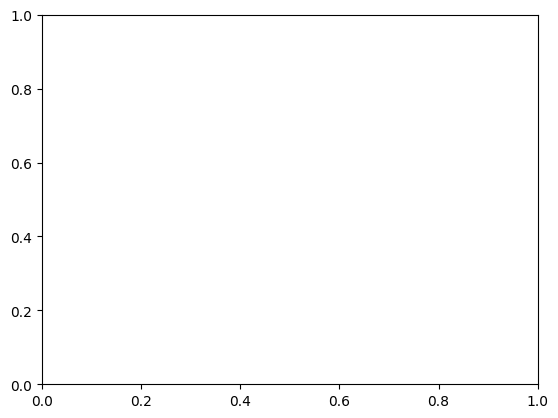

In [21]:
import matplotlib.pyplot as plt

starting = 20
end = 36

labels = []
fig, ax = plt.subplots()
# Definindo a paleta de cores
results = {}
sns.set_palette("rocket")

for i in range(starting,end,4):
    dfResultados["Erro "+str(i)] = abs(Xt['Prediction '+str(i)] - Yt['True '+str(i)])
    #dfResultados["Erro "+str(i)] = abs(dfResultados['ExpectedML '+str(i)] - dfResultados['Real Expected'+str(i)])
    labels.append("Erro "+str(i))

sns.boxplot(x="variable", y="value", data=pd.melt(dfResultados[labels]))

plt.title("Erro calculado na Base CDNOW nas Transações do Modelo Bauer")
plt.ylabel("Erro")
plt.xlabel("Período")
ax.set_xticklabels(labels, rotation=45)
plt.show()



### CDNOW

In [22]:
datasetName = "CDNOW"
Xt =  pd.read_csv("Arquivos/Prediction CDNOW numberOfOrders.csv")
Yt = pd.read_csv("Arquivos/True CDNOW numberOfOrders.csv")

Xm = pd.read_csv("Arquivos/Prediction CDNOW meanOrderProfit.csv")
Ym = pd.read_csv("Arquivos/True CDNOW meanOrderProfit.csv")

dfBauer = pd.read_csv("Arquivos/CDNOW_FINAL.csv")

dfUnprocesses = pd.read_csv("Arquivos/customerOrderDT_CDNOW Clean.csv")
dfUnprocesses['OrderDate'] = pd.to_datetime(dfUnprocesses['OrderDate'])
dfUnprocesses.dropna(inplace = True)
dfUnprocesses = dfUnprocesses[dfUnprocesses["CustomerID"].isin(dfBauer.CustomerID.astype(int).values)]

indexOfComparisson = 72
targetTimeLength = 4 
seqInLength = 2*targetTimeLength
seqOutLength = targetTimeLength
training_start,training_end,holdout_start,holdout_end = getBauerDatasetSplitTimes(dfBauer.reset_index().WeekID,seqOutLength)
targetTimeLength = holdout_end - holdout_start
numSeqFeat = dfBauer.columns.difference(["CustomerID","WeekID"]).size
seqFeatVec = dfBauer.columns.difference(["CustomerID","WeekID"])
training_start = 40


In [23]:
weeks = dfBauer.WeekID.nunique()
customers = dfBauer.CustomerID.nunique()
numTransactions = dfUnprocesses.CustomerID.size
userTransactions = dfUnprocesses.groupby("CustomerID").ItemProfit.count()
mediaTransacoes = userTransactions.mean()
modaTransacao = userTransactions.mode().iloc[0]
minTransaction = userTransactions.min()
maxTransaction = userTransactions.max()

metricas = { "CDNOW" : {
    "Periodos (Semanas)" : weeks,
    "Usuários" : customers,
    "Total Transações" : numTransactions,
    "Média Transações" : mediaTransacoes,
    "Minímo de Transações" : minTransaction,
    "Máximo de transações" : maxTransaction,
    "Moda de transações" : modaTransacao
}}
metricas


pd.DataFrame(metricas)

,CDNOW
Minímo de Transações,1.000000
Moda de transações,2.000000
Máximo de transações,9.000000
Média Transações,3.253205
Periodos (Semanas),78.000000
Total Transações,1015.000000
Usuários,312.000000


### Shopping Data

In [35]:
datasetName = "Shopping"

Xt =  pd.read_csv("Arquivos/Prediction ShoppingData numberOfOrders.csv")
Yt = pd.read_csv("Arquivos/True ShoppingData numberOfOrders.csv")


Xm = pd.read_csv("Arquivos/Prediction ShoppingData meanOrderProfit.csv")
Ym = pd.read_csv("Arquivos/True ShoppingData meanOrderProfit.csv")


dfBauer = pd.read_csv("Arquivos/Shopping_FINAL.csv")

dfUnprocesses = pd.read_csv("Arquivos/customerOrderDT_Shopping Clean.csv")
dfUnprocesses['OrderDate'] = pd.to_datetime(dfUnprocesses['OrderDate'])
dfUnprocesses['OrderDate']  = dfUnprocesses['OrderDate'].dt.tz_convert(None)
dfUnprocesses.dropna(inplace = True)
dfUnprocesses = dfUnprocesses[dfUnprocesses["CustomerID"].isin(dfBauer.CustomerID.values)]


training_start,training_end,holdout_start,holdout_end = 8,12,16,17
indexOfComparisson = 20





In [36]:
weeks = dfBauer.WeekID.nunique()
customers = dfBauer.CustomerID.nunique()
numTransactions = dfUnprocesses.CustomerID.size
userTransactions = dfUnprocesses.groupby("CustomerID").ItemProfit.count()
mediaTransacoes = userTransactions.mean()
modaTransacao = userTransactions.mode().iloc[0]
minTransaction = userTransactions.min()
maxTransaction = userTransactions.max()

metricas = { "Shopping Data" : {
    "Periodos (Semanas)" : weeks,
    "Usuários" : customers,
    "Total Transações" : numTransactions,
    "Média Transações" : mediaTransacoes,
    "Minímo de Transações" : minTransaction,
    "Máximo de transações" : maxTransaction,
    "Moda de transações" : modaTransacao
}}
metricas


pd.DataFrame(metricas)

,Shopping Data
Minímo de Transações,1.000000
Moda de transações,1.000000
Máximo de transações,6.000000
Média Transações,1.198232
Periodos (Semanas),22.000000
Total Transações,62882.000000
Usuários,52479.000000


### Bank Data 1

In [ ]:
datasetName = "Bank Data 1"

Xt =  pd.read_csv("Arquivos/Prediction BANKData1 numberOfOrders.csv")
Yt = pd.read_csv("Arquivos/True BANKData1 numberOfOrders.csv")


Xm = pd.read_csv("Arquivos/Prediction BANKData1 meanOrderProfit.csv")
Ym = pd.read_csv("Arquivos/True BANKData1 meanOrderProfit.csv")

dfUnprocesses = pd.read_csv("Arquivos/customerOrderDT_Bank CleanIDS.csv")
dfUnprocesses['OrderDate'] = pd.to_datetime(dfUnprocesses['OrderDate'])

dfUnprocesses.dropna(inplace = True)

dfBauer = pd.read_csv("Arquivos/BANK_DATA_FINAL.csv")

dfUnprocesses = dfUnprocesses[dfUnprocesses["CustomerID"].isin(dfBauer.CustomerID.values)]
dfUnprocesses = dfUnprocesses.drop(["Unnamed: 0.1","Unnamed: 0"],axis =1)
dfBauer = dfBauer.drop(["Unnamed: 0"],axis =1)


training_start,training_end,holdout_start,holdout_end = getBauerDatasetSplitTimes(dfBauer.reset_index().WeekID,seqOutLength)
training_start = 12
indexOfComparisson = 40


In [ ]:
weeks = dfBauer.WeekID.nunique()
customers = dfBauer.CustomerID.nunique()
numTransactions = dfUnprocesses.CustomerID.size
userTransactions = dfUnprocesses.groupby("CustomerID").ItemProfit.count()
mediaTransacoes = userTransactions.mean()
modaTransacao = userTransactions.mode().iloc[0]
minTransaction = userTransactions.min()
maxTransaction = userTransactions.max()

metricas = { "Bank Data 1" : {
    "Periodos (Semanas)" : weeks,
    "Usuários" : customers,
    "Total Transações" : numTransactions,
    "Média Transações" : mediaTransacoes,
    "Minímo de Transações" : minTransaction,
    "Máximo de transações" : maxTransaction,
    "Moda de transações" : modaTransacao
}}
metricas


pd.DataFrame(metricas)

### Bank Data 2

In [ ]:
dfUnprocesses = pd.read_csv("Arquivos/customerOrderDT_CzechClean.csv")
dfUnprocesses

In [ ]:
datasetName = "Bank Data 2"
#df = pd.read_csv("../Dados/Modelos Bauer/CzechBank.csv")

Xt =  pd.read_csv("Arquivos/Prediction BANKData2 numberOfOrders.csv")
Yt = pd.read_csv("Arquivos/True BANKData2 numberOfOrders.csv")


Xm = pd.read_csv("Arquivos/Prediction BANKData2 meanOrderProfit.csv")
Ym = pd.read_csv("Arquivos/True BANKData2 meanOrderProfit.csv")

dfBauer = pd.read_csv("Arquivos/CzechBank_FINAL.csv")

dfUnprocesses = pd.read_csv("Arquivos/customerOrderDT_CzechClean.csv")

training_start,training_end,holdout_start,holdout_end = getBauerDatasetSplitTimes(dfBauer.reset_index().WeekID,seqOutLength)

dfUnprocesses = dfUnprocesses[dfUnprocesses["CustomerID"].isin(dfBauer.CustomerID.values)]

targetTimeLength = holdout_end - holdout_start
numSeqFeat = dfBauer.columns.difference(["CustomerID","WeekID"]).size
seqFeatVec = dfBauer.columns.difference(["CustomerID","WeekID"])
training_start = holdout_start - 8
holdout_start = 308
indexOfComparisson = 308



In [ ]:
weeks = dfBauer.WeekID.nunique()
customers = dfBauer.CustomerID.nunique()
numTransactions = dfUnprocesses.CustomerID.size
userTransactions = dfUnprocesses.groupby("CustomerID").ItemProfit.count()
mediaTransacoes = userTransactions.mean()
modaTransacao = userTransactions.mode().iloc[0]
minTransaction = userTransactions.min()
maxTransaction = userTransactions.max()

metricas = { "Bank Data 2" : {
    "Periodos (Semanas)" : weeks,
    "Usuários" : customers,
    "Total Transações" : numTransactions,
    "Média Transações" : mediaTransacoes,
    "Minímo de Transações" : minTransaction,
    "Máximo de transações" : maxTransaction,
    "Moda de transações" : modaTransacao
}}
metricas


pd.DataFrame(metricas).astype(int)

### Olist

In [ ]:
dfUnprocesses = pd.read_csv("Arquivos/customerOrderDT_Olist Clean.csv")
dfUnprocesses

In [ ]:
datasetName = "Olist"

Xt =  pd.read_csv("Arquivos/Prediction Olist numberOfOrders.csv")
Yt = pd.read_csv("Arquivos/True Olist numberOfOrders.csv")


Xm = pd.read_csv("Arquivos/Prediction Olist meanOrderProfit.csv")
Ym = pd.read_csv("Arquivos/True Olist meanOrderProfit.csv")

dfBauer = pd.read_csv("Arquivos/Olist_FINAL.csv")

dfUnprocesses = pd.read_csv("Arquivos/customerOrderDT_Olist Clean.csv")


custData = dfUnprocesses.groupby(["customer_unique_id"]).count()
repeatTransactionsDataset = dfUnprocesses[dfUnprocesses.customer_unique_id.isin(custData[custData.WeekID > 2].index.values)]
repeatTransactionsDataset["CustomerID"] = repeatTransactionsDataset.customer_unique_id.astype('category').cat.codes
repeatTransactionsDataset["CustomerID"] = repeatTransactionsDataset.CustomerID.astype(int)
repeatTransactionsDataset['OrderDate'] = pd.to_datetime(repeatTransactionsDataset['OrderDate'])
repeatTransactionsDataset

dfUnprocesses = repeatTransactionsDataset
dfUnprocesses = dfUnprocesses[dfUnprocesses["CustomerID"].isin(dfBauer.CustomerID.values)]


training_start,training_end,holdout_start,holdout_end = 50,90,91,95
targetTimeLength = holdout_end - holdout_start
numSeqFeat = dfBauer.columns.difference(["CustomerID","WeekID"]).size
seqFeatVec = dfBauer.columns.difference(["CustomerID","WeekID"])
start = training_end - 4
end = holdout_end
indexOfComparisson = 94


In [ ]:
weeks = dfBauer.WeekID.nunique()
customers = dfBauer.CustomerID.nunique()
numTransactions = dfUnprocesses.CustomerID.size
userTransactions = dfUnprocesses.groupby("CustomerID").ItemProfit.count()
mediaTransacoes = userTransactions.mean()
modaTransacao = userTransactions.mode().iloc[0]
minTransaction = userTransactions.min()
maxTransaction = userTransactions.max()

metricas = { "Olist" : {
    "Periodos (Semanas)" : weeks,
    "Usuários" : customers,
    "Total Transações" : numTransactions,
    "Média Transações" : mediaTransacoes,
    "Minímo de Transações" : minTransaction,
    "Máximo de transações" : maxTransaction,
    "Moda de transações" : modaTransacao
}}
metricas


pd.DataFrame(metricas).astype(int)

### Real

In [ ]:
datasetName = "Real"
dfBauer = pd.read_csv("Arquivos/Real_FINAL.csv")
targetTimeLength = 4 
seqInLength = 2*targetTimeLength
seqOutLength = targetTimeLength
training_start,training_end,holdout_start,holdout_end = getBauerDatasetSplitTimes(dfBauer.reset_index().WeekID,seqOutLength)
targetTimeLength = holdout_end - holdout_start
numSeqFeat = dfBauer.columns.difference(["CustomerID","WeekID"]).size
seqFeatVec = dfBauer.columns.difference(["CustomerID","WeekID"])
dfUnprocesses = pd.read_csv("Arquivos/customerOrderDT_Real Clean.csv")
dfUnprocesses['OrderDate'] = pd.to_datetime(dfUnprocesses['OrderDate'])

dfUnprocesses = dfUnprocesses[dfUnprocesses["CustomerID"].isin(dfBauer.CustomerID.values)]

indexOfComparisson = 14

training_start = 2
holdout_start = 10

In [ ]:
weeks = dfBauer.WeekID.nunique()
customers = dfBauer.CustomerID.nunique()
numTransactions = dfUnprocesses.CustomerID.size
userTransactions = dfUnprocesses.groupby("CustomerID").ItemProfit.count()
mediaTransacoes = userTransactions.mean()
modaTransacao = userTransactions.mode().iloc[0]
minTransaction = userTransactions.min()
maxTransaction = userTransactions.max()

metricas = { "Real" : {
    "Periodos (Semanas)" : weeks,
    "Usuários" : customers,
    "Total Transações" : numTransactions,
    "Média Transações" : mediaTransacoes,
    "Minímo de Transações" : minTransaction,
    "Máximo de transações" : maxTransaction,
    "Moda de transações" : modaTransacao
}}
metricas


pd.DataFrame(metricas)

### Solução

In [38]:
from sklearn.ensemble import GradientBoostingRegressor


#def testeStacking(
bauerTrainCols =  ['CustomerID', 'WeekID', 'sumProfit', 'numberOfUniqueItems','timeSinceLastPurchase', 'timeSinceFirstPurchase', 'cumSumPurchases',"numberOfOrders", "meanOrderProfit"]
df = dfUnprocesses
dfBauer = dfBauer
minTraining = training_start #Qual é o periodo mínimo que será usado para treino
maxTraining = holdout_start #Qual será o último período que será usado para o treino
intervalosPredicao = 4 #Define quantos períodos serão os intervalos de predição
cID = "CustomerID" #Nome da coluna contendo o ID dos clientes
cDate = "OrderDate"#Nome da coluna onde contém a data das compras
cMonetary = 'ItemProfit' #Nome da coluna onde contém a média dos valores monetários
frequencia = "W"
calculateTransactions = True
calculateMonetary = True
calculateENIAC = True
penalizer = 0.01
bauerModel = True
#segregateCols = ["numberOfOrders","sumProfit"]
segregateCols = ["frequency","recency","monetary_value"]
results = []


def executaSBBD():
    dfResultados =  summary_data_from_transaction_data(df[df["WeekID"] <= maxTraining], 
                                                    cID, 
                                                    cDate, 
                                                    monetary_value_col = cMonetary,freq = frequencia).reset_index()[[cID]].set_index(cID)
    
    
    for periodo in range(minTraining,maxTraining,intervalosPredicao):
        calibrationDate = periodo #8
        #Validar com os próximos intervalos.
        validationEnd = periodo + intervalosPredicao       #12 
        predictDate = periodo + (intervalosPredicao*2)    #16
        print(calibrationDate,validationEnd,predictDate)   
    
    
        XTrain = summary_data_from_transaction_data(df[df["WeekID"] <= calibrationDate], 
                                                   cID, cDate, 
                                                   monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        Ytrain = summary_data_from_transaction_data(df[df["WeekID"] <= validationEnd], 
                                                    cID, 
                                                    cDate, 
                                                    monetary_value_col = cMonetary,
                                                   freq = frequencia)
    
        Ytrain = Ytrain.rename(columns={"frequency" : "frequency_holdout", "monetary_value" : "monetary_holdout"})[["frequency_holdout","monetary_holdout"]]
    
        
        XTest = summary_data_from_transaction_data(df[df["WeekID"] <= validationEnd], cID, cDate, monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        YTest = summary_data_from_transaction_data(df[df["WeekID"] <= predictDate], cID, cDate, monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        
        YTest = YTest.rename(columns={"frequency" : "frequency_holdout", "monetary_value" : "monetary_holdout"})[["frequency_holdout","monetary_holdout"]]
        
        
        #XTrain = pd.merge(XTrain, Ytrain,how='inner',left_index=True, right_index=True)
        #XTest = pd.merge(XTest, YTest,how='inner',left_index=True, right_index=True)
    
    
        XTrain = pd.merge(XTrain, dfBauer[dfBauer["WeekID"] == calibrationDate].set_index("CustomerID"),how='left',left_index=True, right_index=True)
        XTest = pd.merge(XTest, dfBauer[dfBauer["WeekID"] == validationEnd].set_index("CustomerID"),how='left',left_index=True, right_index=True)
    
        YTest =  YTest[YTest.index.isin(XTest.index.values)]
        Ytrain =  Ytrain[Ytrain.index.isin(XTrain.index.values)]
    
        trainingCols = XTrain.columns.values
    
        if segregateCols != []:
            bestColsName = ["Best " + sub for sub in segregateCols] 
            
            for col in segregateCols:
                XTrain["Best "+col] = separaPorcentagem(XTrain,col)
                XTest["Best "+col] = separaPorcentagem(XTest,col)
        
            XTrain["Categories"] = XTrain[bestColsName].dot(XTrain[bestColsName].columns + ', ').str.rstrip(', ')
            XTest["Categories"] = XTest[bestColsName].dot(XTest[bestColsName].columns + ', ').str.rstrip(', ')
        bestColsName+= ["Categories"]
    
        if calculateTransactions:
            start_time = time.time()
            modelML = escolheModeloCustom(XTrain[trainingCols], XTest[trainingCols], Ytrain['frequency_holdout'], YTest['frequency_holdout']#
                      ,target = 'frequency_holdout' #Nome da coluna de target, sendo a coluna de valor monetário prevista ou frequência
                      , tunning = False #Caso queira fazer o Tunning de hyperparâmetros, deixar como true
                     )
            end_time = time.time()
            results.append({
                "Period" : predictDate,
                "Model": "Transactions Machine Learning Model",
                "Training Time (seconds)": end_time - start_time

            })

            ## Adicionando os resultados para os modelos de Stacking
            XTest['ExpectedMLT '+str(predictDate)] = modelML.predict(XTest[trainingCols])
            XTrain['ExpectedMLT '+str(predictDate)] = modelML.predict(XTrain[trainingCols])
    
            start_time = time.time()
            stackModel = stackingModel(XTrain[np.append('ExpectedMLT '+str(predictDate),trainingCols)]
                                       , XTest[np.append('ExpectedMLT '+str(predictDate),trainingCols)]
                                       , Ytrain['frequency_holdout'], YTest['frequency_holdout'])
    
            end_time = time.time()
            results.append({
                "Period" : predictDate,
                "Model": "Transactions Stacking Model",
                "Training Time (seconds)": end_time - start_time

            })
            XTest['ExpectedMLT Stacking'+str(predictDate)] = stackModel.predict(XTest[np.append('ExpectedMLT '+str(predictDate),trainingCols)])
    
            XTest['Real Expected Transactions'+str(predictDate)] = YTest['frequency_holdout']
            XTest['ExpectedMLT Separated Transactions'+str(predictDate)] = None

            start_time = time.time()
            for category in XTest.Categories.unique():
                separatedXTrain = XTrain[XTrain["Categories"] == category][trainingCols]
                separatedYTrain = Ytrain[Ytrain.index.isin(separatedXTrain.index)]
                separatedXTest = XTest[XTest["Categories"] == category][trainingCols]
                separatedYTest = YTest[YTest.index.isin(separatedXTest.index)]
                if len(separatedXTrain) > 10:
                    modelML = escolheModeloCustom(separatedXTrain, separatedXTest, separatedYTrain['frequency_holdout'], separatedYTest['frequency_holdout']#
                          ,target = 'frequency_holdout' #Nome da coluna de target, sendo a coluna de valor monetário prevista ou frequência
                          , tunning = False #Caso queira fazer o Tunning de hyperparâmetros, deixar como true
                         )
        
                    separatedXTest["predictResult"] = modelML.predict(separatedXTest[trainingCols])
    
                    XTest['ExpectedMLT Separated Transactions'+str(predictDate)] = XTest['ExpectedMLT Separated Transactions'+str(predictDate)].combine_first(separatedXTest["predictResult"])
    
            end_time = time.time()
            results.append({
                "Period" : predictDate,
                "Model": "Transactions Separated Model",
                "Training Time (seconds)": end_time - start_time

            })
            #dfResultados[dfResultados['ExpectedML '+str(periodo + (intervalosPredicao*2))] < 0]= 0
        if calculateMonetary:
            start_time = time.time()
            modelML = escolheModeloCustom(XTrain[trainingCols], XTest[trainingCols], Ytrain['monetary_holdout'], YTest['monetary_holdout']#
                      ,target = 'monetary_holdout' #Nome da coluna de target, sendo a coluna de valor monetário prevista ou frequência
                      , tunning = False #Caso queira fazer o Tunning de hyperparâmetros, deixar como true
                     )
            
            end_time = time.time()
            results.append({
                "Period" : predictDate,
                "Model": "Monetary Machine Learning Model",
                "Training Time (seconds)": end_time - start_time

            })
            XTest['ExpectedMLM '+str(predictDate)] = modelML.predict(XTest[trainingCols])
            XTrain['ExpectedMLM '+str(predictDate)] = modelML.predict(XTrain[trainingCols])

            start_time = time.time()
            stackModel = stackingModel(XTrain[np.append('ExpectedMLM '+str(predictDate),trainingCols)]
                               , XTest[np.append('ExpectedMLM '+str(predictDate),trainingCols)]
                               , Ytrain['monetary_holdout'], YTest['monetary_holdout'])
            end_time = time.time()
            results.append({
                "Period" : predictDate,
                "Model": "Monetary Stacking Model",
                "Training Time (seconds)": end_time - start_time

            })
            XTest['ExpectedMLM Stacking'+str(predictDate)] = stackModel.predict(XTest[np.append('ExpectedMLM '+str(predictDate),trainingCols)])
            
            XTest['Real Expected Monetary'+str(predictDate)] = YTest['monetary_holdout']
            XTest['ExpectedMLT Separated Monetary'+str(predictDate)] = None
            
            start_time = time.time()
            for category in XTest.Categories.unique():
                separatedXTrain = XTrain[XTrain["Categories"] == category][trainingCols]
                separatedYTrain = Ytrain[Ytrain.index.isin(separatedXTrain.index)]
                separatedXTest = XTest[XTest["Categories"] == category][trainingCols]
                separatedYTest = YTest[YTest.index.isin(separatedXTest.index)]
                if len(separatedXTrain) > 10:
                    modelML = escolheModeloCustom(separatedXTrain, separatedXTest, separatedYTrain['monetary_holdout'], separatedYTest['monetary_holdout']#
                          ,target = 'monetary_holdout' #Nome da coluna de target, sendo a coluna de valor monetário prevista ou frequência
                          , tunning = False #Caso queira fazer o Tunning de hyperparâmetros, deixar como true
                         )
        
                    separatedXTest["predictResult"] = modelML.predict(separatedXTest[trainingCols])
                    #XTest['ExpectedMLT Separated Monetary'+str(predictDate)] = pd.concat([XTest['ExpectedMLT Separated Monetary'+str(predictDate)], separatedXTest["predictResult"]],axis = 1)
                    XTest['ExpectedMLT Separated Monetary'+str(predictDate)] = XTest['ExpectedMLT Separated Monetary'+str(predictDate)].combine_first(separatedXTest["predictResult"])
    
                    #XTest['ExpectedMLT Separated Monetary'+str(predictDate)]  = separatedXTest["predictResult"]
            end_time = time.time()
            results.append({
                "Period" : predictDate,
                "Model": "Monetary Separated Model",
                "Training Time (seconds)": end_time - start_time

            })      
    
    
        if bauerModel:
                
                #bauerResults = individualTestProphet(dfBauer,weekID = calibrationDate)
                bauerTrain = dfBauer[dfBauer["CustomerID"].isin(XTrain.index)]
                bauerTest = dfBauer[dfBauer["CustomerID"].isin(XTest.index)]
            
                start_time = time.time()
                bauerResults = MixedSolution(bauerTrain,bauerTest,calibrationDate,Ytrain,YTest)
                end_time = time.time()
                results.append({
                    "Period" : predictDate,
                    "Model": "Mixed  Model",
                    "Training Time (seconds)": end_time - start_time
    
                })   
                dfResultados = pd.merge(dfResultados,bauerResults,how = "left",
                            left_index=True, right_index=True)
                
                #dfResultados['ExpectedBauerML '+str(target)+" "+str(i+4)] = bauerResults['ExpectedML '+str(target)+" "+str(i+4)]
        
        dfResultados = pd.merge(dfResultados,XTest.drop(np.append(trainingCols,bestColsName),axis = 1),how = "left",
                            left_index=True, right_index=True)
            #dfResultados[dfResultados['ExpectedML '+str(periodo + (intervalosPredicao*2))] < 0]= 0
    if calculateENIAC:
        dfResultados = PredictENIAC(dfResultados)
        
    dfResultados.fillna(-1,inplace = True)
    return dfResultados

#dfResultados
dfResultados = executaSBBD()


8 12 16
Training with in : 8
Using 12 to validate
Predicting 16
Training with in : 8
Using 12 to validate
Predicting 16
12 16 20
Training with in : 12
Using 16 to validate
Predicting 20
Training with in : 12
Using 16 to validate
Predicting 20
8 12 16
Periodo 8 de 16


<lifetimes.ParetoNBDFitter: fitted with 8257 subjects, alpha: 26.42, beta: 0.00, r: 1.12, s: 0.00>
LassoCV  mse: 0.1655 

ElasticNet  mse: 0.2248 

RandomForestRegressor  mse: 0.1578 

GradientBoostingRegressor  mse: 0.1578 

HistGradientBoostingRegressor  mse: 0.1566 

XGBRegressor  mse: 0.1579 

LGBMRegressor  mse: 0.1562 

LassoCV  mse: 63.3228 

ElasticNet  mse: 63.9183 

RandomForestRegressor  mse: 61.0834 

GradientBoostingRegressor  mse: 60.8468 

HistGradientBoostingRegressor  mse: 61.0340 

XGBRegressor  mse: 61.0076 

LGBMRegressor  mse: 60.9999 

12 16 20
Periodo 12 de 16


<lifetimes.ParetoNBDFitter: fitted with 22622 subjects, alpha: 37.47, beta: 0.00, r: 1.19, s: 0.00>
LassoCV  mse: 0.0741 

ElasticNet  mse:

In [37]:
"""
Calculo do Pareto / ENIAC / BGNBD


"""
def PredictENIAC(dfResultados):
    for periodo in range(minTraining,maxTraining,intervalosPredicao):
        calibrationDate = periodo #8
        #Validar com os próximos intervalos.
        validationEnd = periodo + intervalosPredicao       #12 
        predictDate = periodo + (intervalosPredicao*2)    #16
        print(calibrationDate,validationEnd,predictDate)   
    
    
        XTrain = summary_data_from_transaction_data(df[df["WeekID"] <= calibrationDate], 
                                                   cID, cDate, 
                                                   monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        Ytrain = summary_data_from_transaction_data(df[df["WeekID"] <= validationEnd], 
                                                    cID, 
                                                    cDate, 
                                                    monetary_value_col = cMonetary,
                                                   freq = frequencia)
    
        Ytrain = Ytrain.rename(columns={"frequency" : "frequency_holdout", "monetary_value" : "monetary_holdout"})[["frequency_holdout","monetary_holdout"]]
    
        
        XTest = summary_data_from_transaction_data(df[df["WeekID"] <= validationEnd], cID, cDate, monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        YTest = summary_data_from_transaction_data(df[df["WeekID"] <= predictDate], cID, cDate, monetary_value_col = cMonetary,
                                                   freq = frequencia
                                                  )
        
        YTest = YTest.rename(columns={"frequency" : "frequency_holdout", "monetary_value" : "monetary_holdout"})[["frequency_holdout","monetary_holdout"]]
        
        #XTrain = pd.concat([XTrain, Ytrain], axis=1, join="inner")
        #XTest = pd.concat([XTest, YTest], axis=1, join="inner")
        XTrain = pd.merge(XTrain, Ytrain,how='inner',left_index=True, right_index=True)
        XTest = pd.merge(XTest, YTest,how='inner',left_index=True, right_index=True)
        if calculateTransactions:
            start_time = time.time()
            print(f"Periodo {periodo} de {maxTraining}\n\n")
            #print("Criando modelo BG/NBD")
            modelBGF = criarModeloBGF(XTrain, teste = False,penalizer = penalizer)
            end_time = time.time()
            results.append({
                    "Period" : predictDate,
                    "Model": "BGF ",
                    "Training Time (seconds)": end_time - start_time
    
                })   
            #print(modelBGF)
            start_time = time.time()
           # print("Criando modelo Pareto")
            modelPareto = criarModeloPareto(XTrain,teste = False,penalizer = penalizer)
            end_time = time.time()
            results.append({
                    "Period" : predictDate,
                    "Model": "Pareto ",
                    "Training Time (seconds)": end_time - start_time
    
                })    
            print(modelPareto)
            end = time.time()
            #print("Tempo Pareto: ",timedelta(seconds = end - start))
    
            start_time = time.time()
            modelML = escolheModelo(XTrain,target = 'frequency_holdout')
            end_time = time.time()
            results.append({
                    "Period" : predictDate,
                    "Model": "Transactions ENIAC",
                    "Training Time (seconds)": end_time - start_time
    
                })   
            #print("Tempo ML: ",timedelta(seconds = end - start))
    
            
            XTest['Expected ENIAC Transactions '+str(predictDate)] = modelML.predict(XTest[['frequency', 'recency', 'T', 'monetary_value']])
            #XTest['Real Expected Transactions'+str(predictDate)] = YTest['frequency_holdout']
            XTest['Expected Pareto '+str(predictDate)] = comprasEsperadas(modelPareto, XTest,numPeriodos = 7*intervalosPredicao,teste = False)
            XTest['Expected BGF '+str(predictDate)] = comprasEsperadas(modelBGF, XTest,numPeriodos = 7*intervalosPredicao,teste = False)
    
            #dfResultados[dfResultados['ExpectedML '+str(periodo + (intervalosPredicao*2))] < 0]= 0
        if calculateMonetary:
            start_time = time.time()
            ggf = preverValorGGF(XTrain, #Dataset já processado pelo RFM
                   coefPenalizacao = penalizer, #Coeficiente de penalização utilizada pelo Gamma Gamma
                   teste = False #Caso seja para efetuar a predição em um dataset com ou sem o período de observação
                  )
    
            end_time = time.time()
            results.append({
                    "Period" : predictDate,
                    "Model": "Gamma Gamma ",
                    "Training Time (seconds)": end_time - start_time
    
                })  
            XTest['Expected GGF '+str(predictDate)] = ggf.conditional_expected_average_profit(XTest["frequency"], XTest["monetary_value"]).values
            
            
            start_time = time.time()
            modelML = escolheModelo(XTrain,target = 'monetary_holdout')
            end_time = time.time()
            results.append({
                    "Period" : predictDate,
                    "Model": "Monetary ENIAC ",
                    "Training Time (seconds)": end_time - start_time
    
                })   
            #print("Tempo MLT: ",timedelta(seconds = end - start))
            XTest['Expected ENIAC Monetary '+str(predictDate)] = modelML.predict(XTest[['frequency', 'recency', 'T', 'monetary_value']])
            #XTest['Real Expected Monetary'+str(predictDate)] = YTest['monetary_holdout']
    
        dfResultados = pd.merge(dfResultados,XTest.drop(['frequency', 'recency', 'T', 'monetary_value', 'frequency_holdout',
       'monetary_holdout'], axis = 1),how = "left",
                            left_index=True, right_index=True)
    return dfResultados
        #dfResultados[dfResultados['ExpectedML '+str(periodo + (intervalosPredicao*2))] < 0]= 0    
#return dfResultados

In [39]:
results_df = pd.DataFrame(results)
print(results_df)

    Period                                Model  Training Time (seconds)
0       16  Transactions Machine Learning Model                 4.403115
1       16          Transactions Stacking Model                48.601633
2       16         Transactions Separated Model                 7.690721
3       16      Monetary Machine Learning Model                10.302720
4       16              Monetary Stacking Model                85.991663
5       16             Monetary Separated Model                 6.776051
6       16                         Mixed  Model                15.382904
7       20  Transactions Machine Learning Model                18.761425
8       20          Transactions Stacking Model               106.749669
9       20         Transactions Separated Model                 9.598503
10      20      Monetary Machine Learning Model                 9.583206
11      20              Monetary Stacking Model               101.297908
12      20             Monetary Separated Model    

In [40]:
results_df[results_df["Period"] == indexOfComparisson]

,Period,Model,Training Time (seconds)
7,20,Transactions Machine Learning Model,18.761425
8,20,Transactions Stacking Model,106.749669
9,20,Transactions Separated Model,9.598503
10,20,Monetary Machine Learning Model,9.583206
11,20,Monetary Stacking Model,101.297908
12,20,Monetary Separated Model,10.124391
13,20,Mixed Model,21.898540
19,20,BGF,0.327961
20,20,Pareto,225.468356
21,20,Transactions ENIAC,1.528235


In [41]:

Xt

,Unnamed: 0,Prediction 13,Prediction 14,Prediction 15,Prediction 16
0,0,0.509468,0.540587,0.501092,0.501092
1,1,0.781136,0.781136,0.938070,0.791242
2,2,0.670885,0.631389,0.631389,0.631389
3,3,0.781136,0.781136,0.938070,0.791242
4,4,0.101182,0.101182,0.101182,0.101182
...,...,...,...,...,...
52474,52474,0.101182,0.101182,0.101182,0.101182
52475,52475,0.101182,0.101182,0.101182,0.101182
52476,52476,0.101182,0.101182,0.101182,0.101182
52477,52477,0.101182,0.101182,0.101182,0.101182


In [42]:
### dfResultados
BauerT = retornarMétricas( Yt['True '+str(indexOfComparisson)],Xt['Prediction '+str(indexOfComparisson)])
BauerM = retornarMétricas( Ym['True '+str(indexOfComparisson)],Xm['Prediction '+str(indexOfComparisson)])


MLT = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['ExpectedMLT '+str(indexOfComparisson)])
MLM = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['ExpectedMLM '+str(indexOfComparisson)])


MLTStacking = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['ExpectedMLT Stacking'+str(indexOfComparisson)])
MLMStacking = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['ExpectedMLM Stacking'+str(indexOfComparisson)])


MLTBasedT = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['Expected Mixed frequency_holdout '+str(indexOfComparisson)])
MLTBasedM = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['Expected Mixed monetary_holdout '+str(indexOfComparisson)])

#BauerBasedT = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['ExpectedML numberOfOrders '+str(indexOfComparisson)])
#BauerBasedM = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['ExpectedML meanOrderProfit '+str(indexOfComparisson)])


MLTBasedSeparatedT = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['ExpectedMLT Separated Transactions'+str(indexOfComparisson)])
MLTBasedSeparatedM = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['ExpectedMLT Separated Monetary'+str(indexOfComparisson)])


ENIACT = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['Expected ENIAC Transactions '+str(indexOfComparisson)])
ENIACM = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['Expected ENIAC Monetary '+str(indexOfComparisson)])

PARETO = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['Expected Pareto '+str(indexOfComparisson)])
BGNBD = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['Expected BGF '+str(indexOfComparisson)])

GG = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['Expected GGF '+str(indexOfComparisson)])


solucoes = {
    "Bauer Transaction" : BauerT,
    "Bauer Monetary" : BauerM,
    
    "ML T BASED Transactions" : MLT,
    "ML T BASED Monetary" : MLM,
 
    
    "ML-T-Based (Bauer) Transactions" : MLTBasedT,
    "ML-T-Based (Bauer) Monetary" : MLTBasedM,

    #"ML-T-Based (Bauer) Transactions" : BauerBasedT,
    #"ML-T-Based (Bauer) Monetary" : BauerBasedM,
    
    "ML T BASED SEPARATED Transactions" : MLTBasedSeparatedT,
    "ML T BASED SEPARATED Monetary" : MLTBasedSeparatedM, 
   
    "ML-RFM-Based (Eniac) Transactions" : ENIACT,
    "ML-RFM-Based (Eniac)  Monetary" : ENIACM,
    
    "PARETO" : PARETO,
    "BGNBD" : BGNBD,
    "Gamma-Gamma" : GG,

    "Stacking Transactions" : MLTStacking,
    "Stacking Monetary" : MLMStacking
}



pd.DataFrame(solucoes)

KeyError: 'True 20'

In [30]:
transactions =  {    
    "Bauer Transaction" : BauerT,
    "BGNBD" : BGNBD,
    "PARETO" : PARETO,
    "ML-RFM-Based (Eniac) Transactions" : ENIACT,
    "ML-T-Based (Bauer) Transactions" : MLTBasedT,
    "ML T BASED Transactions" : MLT,
    "ML T BASED SEPARATED Transactions" : MLTBasedSeparatedT,

}

pd.DataFrame(transactions)


,Bauer Transaction,BGNBD,PARETO,ML-RFM-Based (Eniac) Transactions,ML-T-Based (Bauer) Transactions,ML T BASED Transactions,ML T BASED SEPARATED Transactions
mean_squared_error,1.092878,2.331434,2.355548,0.102876,0.116578,0.101414,1.460546
mean_absolute_error,0.785573,1.19543,1.207181,0.172326,0.11315,0.159464,0.400022
r2_score,-0.202417,-0.434604,-0.449443,0.936697,0.928266,0.937597,0.10128
max_error,4.691781,4.435858,4.439397,1.963701,2.003156,1.897438,7.0
root_mean_squared_error,1.045408,1.526903,1.534779,0.320743,0.341436,0.318456,1.20853
intervaloConfiancaErros,"(0.7086151772421214, 0.8625305423995617)","(1.0890970298838005, 1.3017630666658278)","(1.1010911786693143, 1.3132712554832637)","(0.1420452946724678, 0.20260707942897793)","(0.07708996547912596, 0.14920911539606174)","(0.12860859455872287, 0.19032029865746042)","(0.27236874299226643, 0.5276759475851)"


In [31]:
monetary =  {    
    "Bauer Monetary" : BauerM,
    "Gamma-Gamma" : GG,
    "ML-RFM-Based (Eniac) Monetary" : ENIACM,
    "ML-T-Based (Bauer) Monetary" : MLTBasedM,
    "ML T BASED Monetary" : MLM,
    "ML T BASED SEPARATED Monetary" : MLTBasedSeparatedM,

}

pd.DataFrame(monetary)

,Bauer Monetary,Gamma-Gamma,ML-RFM-Based (Eniac) Monetary,ML-T-Based (Bauer) Monetary,ML T BASED Monetary,ML T BASED SEPARATED Monetary
mean_squared_error,50.407692,670.078418,8.250426,12.66393,8.455589,20.757695
mean_absolute_error,6.198657,22.936792,1.524351,1.395802,1.647164,1.893588
r2_score,-0.8981,-411.320305,0.902102,0.849732,0.899667,0.753692
max_error,19.8155,54.178721,26.074633,27.362438,24.519953,23.654633
root_mean_squared_error,7.099837,25.885873,2.872356,3.558642,2.90785,4.556061
intervaloConfiancaErros,"(5.812406506761615, 6.5849065473877015)","(21.59363306501406, 24.279950433684967)","(1.2518408482869348, 1.7968610994232257)","(1.0293787602859388, 1.762224945053996)","(1.3789256037403066, 1.915402961074806)","(1.4297309592509693, 2.3574445339728727)"


In [32]:
Xt['Prediction '+str(indexOfComparisson)] * Xm['Prediction '+str(indexOfComparisson)]

0      35.068626
1      35.068626
2      35.068626
3      35.068626
4      35.068626
         ...    
307    35.071751
308    35.079002
309    35.068626
310    35.068626
311    35.068626
Name: Prediction 72, Length: 312, dtype: float64

In [33]:
Xt.fillna(-1,inplace = True)
Xm.fillna(-1,inplace = True)

In [34]:
dfResultados["ENIAC LTV "+str(indexOfComparisson)] = dfResultados['Expected ENIAC Monetary '+str(indexOfComparisson)] * (dfResultados['Expected ENIAC Transactions '+str(indexOfComparisson)])
dfResultados["Real LTV "+str(indexOfComparisson)] =  dfResultados['Real Expected Monetary'+str(indexOfComparisson)] * dfResultados['Real Expected Transactions'+str(indexOfComparisson)]
dfResultados["Segregated LTV "+str(indexOfComparisson)] =  dfResultados['ExpectedMLT Separated Monetary'+str(indexOfComparisson)] * dfResultados['ExpectedMLT Separated Transactions'+str(indexOfComparisson)]
dfResultados["ML Soluction "+str(indexOfComparisson)] =  dfResultados['ExpectedMLM '+str(indexOfComparisson)] * dfResultados['ExpectedMLT '+str(indexOfComparisson)]
dfResultados["Bauer Based LTV "+str(indexOfComparisson)] =  dfResultados['Expected Mixed monetary_holdout '+str(indexOfComparisson)] * dfResultados['Expected Mixed frequency_holdout '+str(indexOfComparisson)]
Xt["LTV "+str(indexOfComparisson)] =  Xt['Prediction '+str(indexOfComparisson)] * Xm['Prediction '+str(indexOfComparisson)]
Yt["LTV "+str(indexOfComparisson)] =  Yt['True '+str(indexOfComparisson)] * Ym['True '+str(indexOfComparisson)]
Xt.fillna(-1,inplace = True)
Yt.fillna(-1,inplace = True)


#dfResultados["Mixed LTV "+str(indexOfComparisson)] =  dfResultados['Real Expected Monetary'+str(indexOfComparisson)] * dfResultados['Real Expected Transactions'+str(indexOfComparisson)]
#dfResultados["Mixed LTV "+str(indexOfComparisson)] =  dfResultados['Expected Mixed monetary_holdout '+str(indexOfComparisson)] * dfResultados['Expected ENIAC Transactions '+str(indexOfComparisson)]


ENIAC = retornarMétricas( dfResultados['Real LTV '+str(indexOfComparisson)],dfResultados['ENIAC LTV '+str(indexOfComparisson)])
MLSolution = retornarMétricas( dfResultados['Real LTV '+str(indexOfComparisson)],dfResultados['ML Soluction '+str(indexOfComparisson)])
BauerBased = retornarMétricas( dfResultados['Real LTV '+str(indexOfComparisson)],dfResultados['Bauer Based LTV '+str(indexOfComparisson)])
Segregated = retornarMétricas( dfResultados['Real LTV '+str(indexOfComparisson)],dfResultados['Segregated LTV '+str(indexOfComparisson)])
Bauer = retornarMétricas( Yt["LTV "+str(indexOfComparisson)],Xt["LTV "+str(indexOfComparisson)])



solucoesLTV = {
    "Bauer" : Bauer,
    "ENIAC" : ENIAC,
    "BauerBased" : BauerBased,
    "Solution" : MLSolution,
    "Segregated" : Segregated,



}



pd.DataFrame(solucoesLTV)

,Bauer,ENIAC,BauerBased,Solution,Segregated
mean_squared_error,250.537227,47.466182,56.68653,44.687807,235.047258
mean_absolute_error,13.418564,4.065849,3.173015,3.821963,5.744614
r2_score,-0.080644,0.939308,0.927518,0.94286,0.699459
max_error,41.659501,38.373836,42.656674,39.326655,98.2
root_mean_squared_error,15.828368,6.88957,7.529046,6.684894,15.331251
intervaloConfiancaErros,"(12.481881479784438, 14.355246025902357)","(3.4432635293837235, 4.688433607297951)","(2.408734940485837, 3.9372946109231264)","(3.2080383653315767, 4.435887643168017)","(4.153508222378384, 7.335719872437433)"


## Exportando os datasets

In [ ]:
path

In [ ]:
import os 

# checking if the directory demo_folder 
# exist or not. 

path = "Results/"+str(datasetName)
if not os.path.exists(path): 
	os.makedirs(path)

pd.DataFrame(solucoesLTV).to_csv(path+"/TabelaLTV.csv")
pd.DataFrame(solucoes).to_csv(path+"/TabelaTransactionsMonetary.csv")
dfResultados.to_csv(path+"/Resultados.csv")
results_df[results_df["Period"] == indexOfComparisson].to_csv(path+"/TempoExecut.csv")

In [ ]:


ENIACBoostedT = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['ExpectedMLT '+str(indexOfComparisson)])
ENIACBoostedM = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['ExpectedMLM '+str(indexOfComparisson)])

ENIACStackingT = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['ExpectedMLT Stacking'+str(indexOfComparisson)])
ENIACStackingM = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['ExpectedMLM Stacking'+str(indexOfComparisson)])

MLTBasedSeparatedT = retornarMétricas( dfResultados['Real Expected Transactions'+str(indexOfComparisson)],dfResultados['ExpectedMLT Separated Transactions'+str(indexOfComparisson)])
MLTBasedSeparatedM = retornarMétricas( dfResultados['Real Expected Monetary'+str(indexOfComparisson)],dfResultados['ExpectedMLT Separated Monetary'+str(indexOfComparisson)])



solucoes = {
    "ENIAC Transactions" : ENIACT,
    "MLT" : MLT,
    "ENIACBoosted Transactions" : ENIACBoostedT,
    "ENIAC Stacking Transactions" : ENIACStackingT,
    #"ML T BASED SEPARATED Transactions" : MLTBasedSeparatedT,
    #"ML T BASED SEPARATED Monetary" : MLTBasedSeparatedM,  
    "ENIAC  Monetary" : ENIACM,
    "ENIACBoosted Monetary" : ENIACBoostedM,
    "ENIAC Stacking Monetary" : ENIACStackingM,
}



pd.DataFrame(solucoes)

In [ ]:
dfResultados["ENIAC LTV "+str(indexOfComparisson)] = dfResultados['Expected ENIAC Monetary '+str(indexOfComparisson)] * (dfResultados['Expected ENIAC Transactions '+str(indexOfComparisson)])
dfResultados["ENIAC Boosted LTV "+str(indexOfComparisson)] = dfResultados['ExpectedMLM '+str(indexOfComparisson)] * (dfResultados['ExpectedMLT '+str(indexOfComparisson)])
dfResultados["Real LTV "+str(indexOfComparisson)] =  dfResultados['Real Expected Monetary'+str(indexOfComparisson)] * dfResultados['Real Expected Transactions'+str(indexOfComparisson)]
dfResultados["ENIAC Stack LTV "+str(indexOfComparisson)] = dfResultados['ExpectedMLM Stacking'+str(indexOfComparisson)] * (dfResultados['ExpectedMLT Stacking'+str(indexOfComparisson)])
dfResultados["Segregated LTV "+str(indexOfComparisson)] =  dfResultados['ExpectedMLT Separated Monetary'+str(indexOfComparisson)] * dfResultados['ExpectedMLT Separated Transactions'+str(indexOfComparisson)]


ENIAC = retornarMétricas( dfResultados['Real LTV '+str(indexOfComparisson)],dfResultados['ENIAC LTV '+str(indexOfComparisson)])
ENIACB = retornarMétricas( dfResultados['Real LTV '+str(indexOfComparisson)],dfResultados['ENIAC Boosted LTV '+str(indexOfComparisson)])
ENIACS = retornarMétricas( dfResultados['Real LTV '+str(indexOfComparisson)],dfResultados['ENIAC Stack LTV '+str(indexOfComparisson)])
ENIACSegregated = retornarMétricas( dfResultados['Real LTV '+str(indexOfComparisson)],dfResultados['Segregated LTV '+str(indexOfComparisson)])

solucoes = {
    "ENIAC" : ENIAC,
    "ENIAC Boosted" : ENIACB,
    "ENIAC Stacked" : ENIACS,
    "ENIAC Segregated" : ENIACSegregated,

}



pd.DataFrame(solucoes)

## Análise dos dados

1. quantos meses tem cada uma das bases de dados
2. quantos usuários tem cada uma das bases de dados
3. quantas transações no total tem cada uma das bases de dados
3. quantas transacoes por usuário (dividir total de transações pelo total de usuários) tem cada uma das bases de dados

### CDNow

In [ ]:
weeks = dfBauer.WeekID.nunique()
customers = dfBauer.CustomerID.nunique()
numTransactions = dfUnprocesses.size
userTransactions = dfUnprocesses.groupby("CustomerID").ItemProfit.count()
mediaTransacoes = userTransactions.mean()
modaTransacao = userTransactions.mode().iloc[0]
minTransaction = userTransactions.min()
maxTransaction = userTransactions.max()

metricas = {
    "Periodos (Semanas)" : weeks,
    "Usuários" : customers,
    "Total Transações" : numTransactions,
    "Média Transações" : mediaTransacoes,
    "Minímo de Transações" : minTransaction,
    "Máximo de transações" : maxTransaction,
    "Moda de transações" : modaTransacao
}
metricas


#pd.DataFrame(metricas)

In [ ]:

Xt =  pd.read_csv("../Dados/Stacking/CDNOW/Prediction CDNOW numberOfOrders.csv")
Yt = pd.read_csv("../Dados/Stacking/CDNOW/True CDNOW numberOfOrders.csv")

Xm = pd.read_csv("../Dados/Stacking/CDNOW/Prediction CDNOW meanOrderProfit.csv")
Ym = pd.read_csv("../Dados/Stacking/CDNOW/True CDNOW meanOrderProfit.csv")

dfBauer = pd.read_csv("../Dados/Modelos Bauer/CDNOW_FINAL.csv")

dfUnprocesses = pd.read_csv("../Dados/Modelos Bauer/customerOrderDT_CDNOW Clean.csv")
dfUnprocesses['OrderDate'] = pd.to_datetime(dfUnprocesses['OrderDate'])
dfUnprocesses.dropna(inplace = True)
dfUnprocesses = dfUnprocesses[dfUnprocesses["CustomerID"].isin(dfBauer.CustomerID.astype(int).values)]


targetTimeLength = 4 
seqInLength = 2*targetTimeLength
seqOutLength = targetTimeLength
training_start,training_end,holdout_start,holdout_end = getBauerDatasetSplitTimes(dfBauer.reset_index().WeekID,seqOutLength)
targetTimeLength = holdout_end - holdout_start
numSeqFeat = dfBauer.columns.difference(["CustomerID","WeekID"]).size
seqFeatVec = dfBauer.columns.difference(["CustomerID","WeekID"])
